In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

/Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Set up important functions

In [2]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

## 2. Describe and process data

In [3]:
TRAIN_SET_PATH  = "./err.train.csv"
TEST_SET_PATH  = "./err.test.csv"

In [4]:
df = describe_dataset(TRAIN_SET_PATH)
# Categorizing label
df.loc[df["label"] == "L", "label"] = 0
df.loc[df["label"] == "C", "label"] = 1

df.tail(3)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 17907 
Number of columns: 53

Labels: 
L    9114
C    8793
Name: label, dtype: int64

Missing values:

,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
17904,1,0.647438,0.442268,0.004114,0.999985,0.615798,0.517170,0.151706,0.999579,0.631354,...,-0.034228,0.979719,0.701826,0.880516,0.134222,0.979319,0.504880,0.881748,-0.027911,0.986165
17905,1,0.649652,0.419057,0.008783,0.999983,0.617577,0.503514,0.158545,0.999529,0.631972,...,-0.061176,0.980431,0.704606,0.880248,0.071476,0.979932,0.504513,0.881766,-0.088832,0.986975
17906,1,0.653556,0.400394,0.014852,0.999980,0.620734,0.486522,0.169807,0.999556,0.631171,...,-0.138678,0.979078,0.705475,0.878981,0.003690,0.979199,0.504067,0.882642,-0.183304,0.986824


In [5]:
with open("./model/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

In [6]:
# Extract features and class
X = df.drop("label", axis=1)
y = df["label"].astype("int")

X = pd.DataFrame(sc.transform(X))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

10827    0
11395    0
3742     1
Name: label, dtype: int64

## 3. Train & Evaluate Model

### 3.1. Train and evaluate model with train set

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier

algorithms =[("HistGradientBoosting", HistGradientBoostingClassifier()),
             ("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[1, 0])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[1, 0])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[1, 0])
    cm = confusion_matrix(y_test, model_results, labels=[1, 0])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,SVC,"[1.0, 0.999]",0.999721,"[0.999, 1.0]","[1.0, 1.0]","[[1713, 1], [0, 1868]]"
1,KNN,"[1.0, 0.998]",0.999162,"[0.998, 1.0]","[0.999, 0.999]","[[1711, 3], [0, 1868]]"
2,RF,"[1.0, 0.998]",0.999162,"[0.998, 1.0]","[0.999, 0.999]","[[1711, 3], [0, 1868]]"
3,HistGradientBoosting,"[0.999, 0.997]",0.998325,"[0.997, 0.999]","[0.998, 0.998]","[[1709, 5], [1, 1867]]"
4,DTC,"[0.994, 0.997]",0.995812,"[0.997, 0.995]","[0.996, 0.996]","[[1709, 5], [10, 1858]]"
5,SGDC,"[0.992, 0.991]",0.991904,"[0.991, 0.993]","[0.992, 0.992]","[[1698, 16], [13, 1855]]"
6,LR,"[0.992, 0.987]",0.989391,"[0.986, 0.993]","[0.989, 0.99]","[[1690, 24], [14, 1854]]"
7,NB,"[0.963, 0.952]",0.957286,"[0.947, 0.967]","[0.955, 0.959]","[[1623, 91], [62, 1806]]"


### 3.2. Test set evaluation

In [9]:
test_df = describe_dataset(TEST_SET_PATH)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Categorizing label
test_df.loc[test_df["label"] == "L", "label"] = 0
test_df.loc[test_df["label"] == "C", "label"] = 1

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

test_x = pd.DataFrame(sc.transform(test_x))

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'left_foot_index_v', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z', 'right_foot_index_v']
Number of rows: 1107 
Number of columns: 53

Labels: 
L    561
C    546
Name: label, dtype: int64

Missing values: Fa

In [10]:
testset_final_results = []

for name, model in models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average=None, labels=[1, 0])
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average=None, labels=[1, 0])
    f1_score_result = f1_score(test_y, model_results, average=None, labels=[1, 0])
    cm = confusion_matrix(test_y, model_results, labels=[1, 0])
    testset_final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm ))


testset_final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,LR,"[0.948, 0.998]",0.971996,"[0.998, 0.947]","[0.972, 0.972]","[[545, 1], [30, 531]]"
1,SGDC,"[0.933, 0.998]",0.963866,"[0.998, 0.93]","[0.965, 0.963]","[[545, 1], [39, 522]]"
2,HistGradientBoosting,"[0.958, 0.961]",0.959350,"[0.96, 0.959]","[0.959, 0.96]","[[524, 22], [23, 538]]"
3,DTC,"[0.921, 0.906]",0.913279,"[0.901, 0.925]","[0.911, 0.915]","[[492, 54], [42, 519]]"
4,RF,"[0.78, 0.899]",0.830172,"[0.914, 0.749]","[0.841, 0.817]","[[499, 47], [141, 420]]"
5,NB,"[0.79, 0.751]",0.768744,"[0.723, 0.813]","[0.755, 0.781]","[[395, 151], [105, 456]]"
6,KNN,"[0.737, 0.799]",0.765131,"[0.815, 0.717]","[0.774, 0.756]","[[445, 101], [159, 402]]"
7,SVC,"[0.659, 0.842]",0.719964,"[0.894, 0.551]","[0.759, 0.666]","[[488, 58], [252, 309]]"


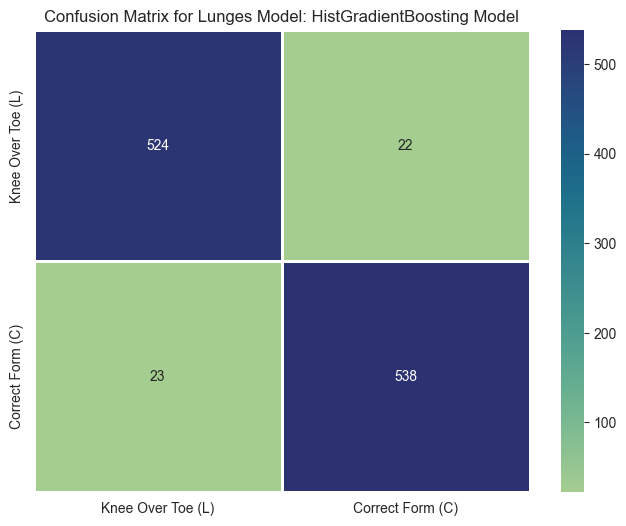

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract the confusion matrix for the best lunges model from testset_final_results
lunges_cm = next(item[5] for item in testset_final_results if item[0] == "HistGradientBoosting")  # Replace "Best Lunges Model" with the actual model name

# Create a DataFrame for the confusion matrix with appropriate labels
cm_df = pd.DataFrame(lunges_cm, 
                     index=["Knee Over Toe (L)", "Correct Form (C)"], 
                     columns=["Knee Over Toe (L)", "Correct Form (C)"])

# Plot the confusion matrix heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="crest", linewidths=1, ax=ax)

# Add title
ax.set_title("Confusion Matrix for Lunges Model: HistGradientBoosting Model")

# Display the plot
plt.show()


## 4. Dump Models 

According to the evaluation above, LR and KNN SGDC would be chosen for more eval.

In [24]:
with open("./model/sklearn/err_all_sklearn_jainil.pkl", "wb") as f:
    pickle.dump(models, f)

In [25]:
with open("./model/sklearn/err_SGDC_model_jainil.pkl", "wb") as f:
    pickle.dump(models["SGDC"], f)

In [26]:
with open("./model/sklearn/err_LR_model_jainil.pkl", "wb") as f:
    pickle.dump(models["LR"], f)

In [27]:
with open("./model/sklearn/err_KNN_model_jainil.pkl", "wb") as f:
    pickle.dump(models["KNN"], f)